### ----------------------------------------------------------------------------------------------------------------------
### Darie-Dragos Mitoiu - 1905367
### CM4107 Advanced Artificial Intelligence
### Handwriting Data v1.0.0 26/10/2020
### A jupyter notebook for the creation of handwriting data
### ----------------------------------------------------------------------------------------------------------------------

In [31]:
import pandas as pd
import numpy as np
import scipy.special
import os 
import imageio
import glob
import operator
from scipy import ndimage
import seaborn as sns
import matplotlib.pyplot as plt

### Setting Preferences

In [32]:
# Setting matplotlib inline
%matplotlib inline

In [33]:
# Setting seaborn style
sns.set_style("darkgrid")

In [34]:
# Setting numpy seed
np.random.seed(42)

In [35]:
def get_my_test_data(folder):
    # our own image test data set
    X = []
    y = []
    
    # to read jpg change the regex to '/*.jpg'
    folder_expr = folder + '/*.png'
    print(folder_expr)

    for image_file_name in glob.glob(folder_expr): 
        print ("loading ... ", image_file_name)

        # load image data from png files into an array
        img_array = imageio.imread(image_file_name, as_gray=True)
        # reshape from 28x28 to list of 784 values, invert values
        img_data  = 255.0 - img_array.reshape(784)
        # then scale data to range from 0.01 to 1.0
        inputs = (img_data / 255.0 * 0.99) + 0.01
        
        # use the filename to set the correct label
        digit_class = int(image_file_name[-5:-4]) #negative indices for indexing from the end of the array
        
        X.insert(len(X), inputs)
        y.insert(len(y), digit_class)
       
        pass
    return(X,y)
pass

handwriting/*.png
loading ...  handwriting\pen_image_0.png
loading ...  handwriting\pen_image_1.png
loading ...  handwriting\pen_image_2.png
loading ...  handwriting\pen_image_3.png
loading ...  handwriting\pen_image_4.png
loading ...  handwriting\pen_image_5.png
loading ...  handwriting\pen_image_6.png
loading ...  handwriting\pen_image_7.png
loading ...  handwriting\pen_image_8.png
loading ...  handwriting\pen_image_9.png


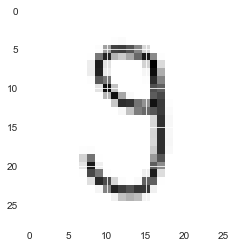

In [55]:
X_my_test, y_my_test = get_my_test_data('handwriting') # my_images is a subfolder in the current folder 

# lets plot one of the created images that was read into X_my_test
# now reshape the 784 features into a 28x28 grid
# here asfarray helps to convert values into real numbers
image_array = np.asfarray(X_my_test[9]).flatten().reshape((28,28))

# print the grid in grey scale
plt.imshow(image_array, cmap='Greys', interpolation='None') 

In [72]:
#MNIST dataset assume output_nodes = 10 for the ANN

# converts the data to a format that the ANN class can use for training the model
# this eseentially , maps a given target class label to an outputs vector (y_vec) thats compatible 
# with the ANN's output layer. 

output_nodes = 10
def map_target_to_output_layer(instances, targets):
    X=[]
    Y=[]
    for inputs, target in zip(instances, targets):
        # create the target output values (all 0.01, except the desired label which is 0.99)
        y_vec = np.zeros(output_nodes) + 0.01
        y_vec[int(target)] = 0.99
        #print('output', target)
        
        X.insert(len(X), inputs) # simply inserting these they are already in the correct format
        Y.insert(len(Y), y_vec) # inserting these after the vector mapping
    pass
    return(X,Y)
pass

X_my_test, y_my_test = get_my_test_data('handwriting')
X_my_test, y_my_test = map_target_to_output_layer(X_my_test, y_my_test)

handwriting/*.png
loading ...  handwriting\pen_image_0.png
loading ...  handwriting\pen_image_1.png
loading ...  handwriting\pen_image_2.png
loading ...  handwriting\pen_image_3.png
loading ...  handwriting\pen_image_4.png
loading ...  handwriting\pen_image_5.png
loading ...  handwriting\pen_image_6.png
loading ...  handwriting\pen_image_7.png
loading ...  handwriting\pen_image_8.png
loading ...  handwriting\pen_image_9.png


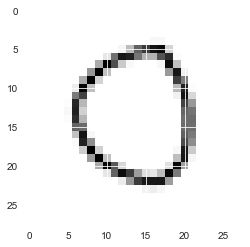

In [38]:
image_array = np.asfarray(X_my_test[0]).flatten().reshape((28,28))
# print the grid in grey scale
plt.imshow(image_array, cmap='Greys', interpolation='None') 

### Set Global Variables

In [39]:
# Set the training file name
train_file = "data/mnist_train.csv"
# The testing file name
test_file = "data/mnist_test.csv"

# Set the number of input nodes
input_nodes = 784
# Set the number of hidden nodes
hidden_nodes = 200
# Set the number of output nodes
output_nodes = 10

# Set the epochs number
epochs = 10
# Set the batch size number
batch_size = 1
# Set the learning rate number
learning_rate = 0.3

### Load MNIST Training and Testing Datasets

In [40]:
# Read the training dataset
df_orig_train = pd.read_csv(train_file, header=None)

### MNIST Training Data Insight

In [41]:
print("The number of records in the mnist training dataset is: ",df_orig_train.shape[0])
print("The number of columns in the mnist training dataset is: ", df_orig_train.shape[1])

The number of records in the mnist training dataset is:  60000
The number of columns in the mnist training dataset is:  785


In [42]:
# Show training dataset relevant information
df_orig_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 359.3 MB


In [43]:
# Show the head of the training dataset
df_orig_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### MNIST Training Data Frame Dimensionality

In [44]:
y_train_all =  pd.get_dummies(df_orig_train[0]).values
X_train_all = df_orig_train.drop(0, axis = 1).values
print(y_train_all.shape)
print(X_train_all.shape)

(60000, 10)
(60000, 784)


### Data Pre-Processing

In [45]:
# Select smaller samples of the train and test datasets
train_sample_size = 1500  # choosing a smaller sample instead of the entire dataset
random_indices = np.random.choice(range(len(y_train_all)), train_sample_size, replace = False)

X_train = X_train_all[random_indices]
y_train = y_train_all[random_indices]
print(y_train.shape)
print(X_train.shape)

#preprocessing steps
X_train = (X_train / 255.0 * 0.99) + 0.01
y_train = y_train + 0.01
y_train = np.where(y_train != 1.01, y_train, 0.99)
print(y_train.shape)

(1500, 10)
(1500, 784)
(1500, 10)


### Utility Functions

In [76]:
def mean_squared_error(predictions, targets):
    """
    Calculates mean squared error of a model's predictions.
    """
    N=len(targets)
    mse = ((targets - predictions) **2).sum() / (2*N)
    return mse


def accuracy(predictions, targets):
    """
    Calculates the accuracy of a model's predictions.
    """
    prediction_labels = np.argmax(predictions, axis=1)
    target_labels = np.argmax(targets, axis=1)
    predictions_correct = (prediction_labels == target_labels.round())
    accuracy = predictions_correct.mean()
    return accuracy

### Activation Classes

In [47]:
class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
    def backward(self, inputs):
        self.output = np.greater(inputs, 0).astype(int) # inputs > 0 then convert bools to int
        
class Activation_Sigmoid:
    def forward(self, x):
        return(1 / (1 + np.exp(-x)))
    def backward(self, x):
        return(x * ( 1 - x))

### Layer Class

In [48]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, learningrate=0.01, activation='sigmoid'):
        
        self.weights = np.random.normal(0.0, pow(n_inputs, -0.5), (n_inputs, n_neurons))
        print(self.weights.shape)
        self.biases = np.zeros((1, n_neurons))
       
        self.lr = learningrate
        self.activate=activation  
        
    def forward(self, inputs):
        self.in_values = inputs
        self.layer_input = np.dot(inputs , self.weights) + self.biases
        self.activation()
    
    def activation(self):
        if self.activate == 'sigmoid':
            a = Activation_Sigmoid()
            self.layer_output = a.forward(self.layer_input)
            
           
    def del_activation(self):
        if self.activate == 'sigmoid':
            del_a = Activation_Sigmoid()
            self.del_layer_output =  del_a.backward(del_a.forward(self.layer_input))
      
    def backward(self, delta_in, weights_in, targets=None, output_layer=False):
        self.del_activation()
        if output_layer:
            self.layer_error = self.layer_output - targets
            self.layer_delta = self.layer_error * self.del_layer_output
        else:          
            self.layer_error = np.dot(delta_in, weights_in.T)
            self.layer_delta = self.layer_error * self.del_layer_output
        
    def weight_update(self, prev_layer_output):
        # print("prev_layer_output.T.shape: "+str(prev_layer_output.T.shape))
        # print("self.layer_delta.shape: "+str(self.layer_delta.shape))
        N = self.layer_delta.shape[0]
        weights_update = np.dot(prev_layer_output.T, self.layer_delta) / N
        # print(weights_update.shape)
        self.weights -= self.lr * weights_update
        biases_update = np.mean(self.layer_delta, axis=0, keepdims=True)
        # print("biases_update.shape: "+ str(biases_update.shape))
        # print("self.biases.shape: "+ str(self.biases.shape))
        self.biases -= self.lr * biases_update

### Creating Layers

In [49]:
layer1 = Layer_Dense(784, 200) # set the weight matrix dimensions (input nodes x hidden nodes)
output = Layer_Dense(200, 10) # set the weight matrix dimensions (hidden nodes x output nodes)

# maintain a dataframe to keep track of the network error
monitoring = {}
monitoring['mean_squared_error'] = []
monitoring['accuracy'] = []

# iterate and update weights at each epoch
for epoch in range(100):
    layer1.forward(X_train)
    # print('layer1 output \n' ,layer1.layer_output.shape)
    output.forward(layer1.layer_output)
    # print('layer output  \n', output.layer_output.shape)

    # train metrics
    pred = output.layer_output
    mse = mean_squared_error(pred, y_train)
    acc = accuracy(output.layer_output, y_train)
    monitoring['mean_squared_error'].append(mse)
    monitoring['accuracy'].append(acc)

    # backprop through the layers 
    output.backward(None, None, y_train, True)
    # print('layer out delta  \n', output.layer_delta.shape)
    layer1.backward(output.layer_delta, output.weights)
    # print('layer1 delta  \n', layer1.layer_delta.shape)

    # update all the layer weights
    output.weight_update(layer1.layer_output)
    # print('layer weights  \n', output.weights.shape)
    layer1.weight_update(X_train)
    # print('layer weights  \n', layer1.weights.shape)

monitoring_df = pd.DataFrame(monitoring)   
monitoring_df

(784, 200)
(200, 10)


,mean_squared_error,accuracy
0,0.116195,0.104000
1,0.111584,0.104000
2,0.107238,0.104000
3,0.103156,0.104000
4,0.099329,0.104000
...,...,...
95,0.044869,0.168667
96,0.044828,0.168667
97,0.044789,0.167333
98,0.044751,0.167333


### Creating Artificial Neural Network

In [50]:
class ANN():
    def __init__(self, ouput_layer, hidden_layer, batch_size = 10):
        self.output = ouput_layer
        self.layer1 = hidden_layer
        self.batch_size = batch_size

    def batch_input(self, x, y):
        for i in range(0, len(x), self.batch_size):
            yield (x[i:i + self.batch_size], y[i:i + self.batch_size])

    def train(self, x, y, epochs, lr):
        self.layer1.lr = lr
        self.output.lr = lr

        monitoring = {}
        monitoring['mean_squared_error'] = []
        monitoring['accuracy'] = []

        for epoch in range(epochs):

            for (batch_x, batch_y) in self.batch_input(x, y):
                self.layer1.forward(batch_x)
                # print('layer1 output \n' ,layer1.layer_output.shape)
                self.output.forward(self.layer1.layer_output)
                # print('layer output  \n', output.layer_output.shape)

                # backprop through the layers 
                self.output.backward(None, None, batch_y, True)
                # print('layer out delta  \n', output.layer_delta.shape)
                self.layer1.backward(self.output.layer_delta, self.output.weights)
                # print('layer1 delta  \n', layer1.layer_delta.shape)

                # update all the layer weights
                self.output.weight_update(self.layer1.layer_output)
                # print('layer weights  \n', output.weights.shape)
                self.layer1.weight_update(batch_x)
                # print('layer weights  \n', layer1.weights.shape)
            pred = self.predict(x)
            mse, acc = self.evaluate(pred, y)
            monitoring['mean_squared_error'].append(mse)
            monitoring['accuracy'].append(acc)

        monitoring_df = pd.DataFrame(monitoring)   
        return monitoring_df

    def predict(self, x):
        self.layer1.forward(x)
        self.output.forward(self.layer1.layer_output)
        return self.output.layer_output

    def evaluate(self, predicts, y):
        mse = mean_squared_error(predicts, y)
        acc = accuracy(predicts, y)
        return mse, acc

    def test(self, x, y):
        monitoring = {}
        pred = self.predict(x)
        mse, acc = self.evaluate(pred, y)
        monitoring['mean_squared_error'] = [mse]
        monitoring['accuracy'] = [acc]
        return pd.DataFrame(monitoring)

### Evaluation of Hyper-Parameters

### Default Hyper-Parameters

In [51]:
np.random.seed(42)

# Configurations of hidden node layer
hidden_nodes = [200, 5]

# Default hyper-parameters
batch_size = 20
epochs = 10
lr = 0.3

### Epochs Testing Values

In [59]:
# Declaring epochs array
epochs_values = [10, 50, 100, 150, 200]

#### Creating Artificial Neural Network Models

In [73]:
epochs_ann_list = []
epochs_train_results_list = []
print("Creating ANN models using the epochs array: ", epochs_values)
for epoch in epochs_values:
    # configure the layers
    epochs_hidden_layer = Layer_Dense(784,200)
    epochs_output_layer = Layer_Dense(200,10)

    # create an ANN model
    epochs_ann = ANN(epochs_output_layer, epochs_hidden_layer, batch_size=20)
    epochs_train_performance = epochs_ann.train(X_train, y_train, epoch, lr=0.3) # train the model

    epochs_train_results_list.append(epochs_train_performance)
    epochs_ann_list.append(epochs_ann) # maintain each ANN model in a list

print("Process Completed.")

Creating ANN models using the epochs array:  [10, 50, 100, 150, 200]
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
(784, 200)
(200, 10)
Process Completed.


#### Evaluating the Accuracy and Error rate of the ANN Models based on the number of Epochs

In [77]:
epochs_test_results_list = []
for model in epochs_ann_list:
    epochs_df_test_result = model.test(X_my_test, y_my_test)
    mse=epochs_df_test_result['mean_squared_error'].values
    acc=epochs_df_test_result['accuracy'].values
    epochs_test_results_list.append((mse[0], acc[0]))
    pass
pass

print ("Mean Squared Error and Accuracy Results \n {}".format(epochs_test_results_list))

Mean Squared Error and Accuracy Results 
 [(0.3975755268594657, 0.3), (0.38415426768914374, 0.4), (0.3835165267700265, 0.6), (0.3811275413632124, 0.5), (0.3792554821946974, 0.5)]


In [78]:
df_epochs_results = pd.DataFrame(epochs_test_results_list, columns=['mean_squared_error', 'accuracy'], index=epochs_values)
df_epochs_results.head()

,mean_squared_error,accuracy
10,0.397576,0.3
50,0.384154,0.4
100,0.383517,0.6
150,0.381128,0.5
200,0.379255,0.5


#### Visualising the results for the array of epochs

Text(0, 0.5, 'Accuracy')

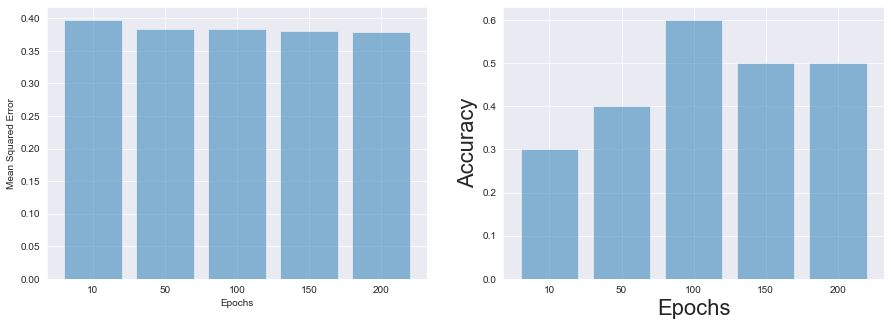

In [79]:
epochs_objects = epochs_values
epochs_performance = epochs_test_results_list

# plot performances bars
epochs_fig, epochs_axes = plt.subplots(1, 2, figsize=(15,5))
y_pos = np.arange(len(epochs_objects))
# get mean squared error from performance
epochs_model_mse = [x[0] for x in epochs_performance]
epochs_axes[0].bar(y_pos, epochs_model_mse, align='center', alpha=0.5)
epochs_axes[0].set_xticks(y_pos)
epochs_axes[0].set_xticklabels(epochs_objects)
epochs_axes[0].set_xlabel("Epochs")
epochs_axes[0].set_ylabel("Mean Squared Error")

# plot accuracy from performance
epochs_model_acc = [x[1] for x in epochs_performance]
epochs_axes[1].bar(y_pos, epochs_model_acc, align='center', alpha=0.5)
epochs_axes[1].set_xticks(y_pos)
epochs_axes[1].set_xticklabels(epochs_objects)
epochs_axes[1].set_xlabel("Epochs", fontsize=22)
epochs_axes[1].set_ylabel("Accuracy", fontsize=22)